In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
import importlib
import utils
importlib.reload(utils)

from utils import compare_vars, corr_plot, normalize, get_seasonal_pattern, features, Data, Seasonality

# Load Data

In [3]:
pred = pd.read_csv('data/dengue_features_train.csv')
resp = pd.read_csv('data/dengue_labels_train.csv')

print(pred.shape)
print(resp.shape)

(1456, 24)
(1456, 4)


In [4]:
pred.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

Some general considerations:

1. There are 1,456 data points and 22 (I'm not counting `total_cases` and `week_start_date`) original features. This means it's unlikely we'll be able to train complex models without running a risk of overfitting. As a result we should focus on simpler models like regression or boosed or bagged trees
2. We're dealing with climate data so we should expect strong seasonal components. This presents a dilemma: whether a model should recognize and incorporate seasonal component as a part of training routine, or we should distill the component separately and then train model on the residuals
3. All link leading to detailed data description are broken (with an exception of NOAA NCEP corresponding to variable names that start with `reanalysis`) so we'll have to find a way of dealing with differences in data from different sources that represent same quantity 


NOAA GHCN temperatures are measured in degrees Celsius while NOAA NCEP temperatures are measured in degrees Kelvin. We'll convert values in Kelvin into Celsius via T(C) = T(K) - 273.15 except for `reanalysis_tdtr_k` as it's a temperature difference

In [5]:
for c in pred.columns:
    if c.endswith('_k'):
        if c == 'reanalysis_tdtr_k':
            pred[c.replace('_k', '_c')] = pred[c]
        else:
            pred[c.replace('_k', '_c')] = pred[c] - 273.15
        pred = pred.drop(columns=[c])

In [6]:
data = pred.merge(resp, on=['city', 'year', 'weekofyear'])

# Stats

In [7]:
data[features + ['total_cases']].describe().T

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,1262.0,0.142294,0.140531,-0.406250,0.044950,0.128817,0.248483,0.508357
ndvi_nw,1404.0,0.130553,0.119999,-0.456100,0.049217,0.121429,0.216600,0.454429
ndvi_se,1434.0,0.203783,0.073860,-0.015533,0.155087,0.196050,0.248846,0.538314
ndvi_sw,1434.0,0.202305,0.083903,-0.063457,0.144209,0.189450,0.246982,0.546017
station_precip_mm,1434.0,39.326360,47.455314,0.000000,8.700000,23.850000,53.900000,543.300000
precipitation_amt_mm,1443.0,45.760388,43.715537,0.000000,9.800000,38.340000,70.235000,390.600000
reanalysis_sat_precip_amt_mm,1443.0,45.760388,43.715537,0.000000,9.800000,38.340000,70.235000,390.600000
reanalysis_precip_amt_kg_per_m2,1446.0,40.151819,43.434399,0.000000,13.055000,27.245000,52.200000,570.500000
reanalysis_relative_humidity_percent,1446.0,82.161959,7.153897,57.787143,77.177143,80.301429,86.357857,98.610000
reanalysis_specific_humidity_g_per_kg,1446.0,16.746427,1.542494,11.715714,15.557143,17.087143,17.978214,20.461429


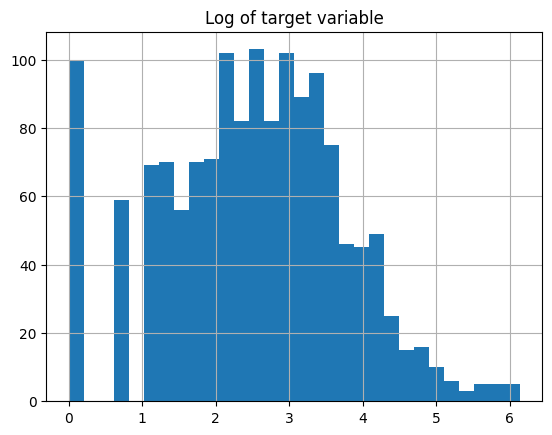

In [8]:
np.log1p(data.total_cases).hist(bins=30)
plt.title('Log of target variable')
plt.show()

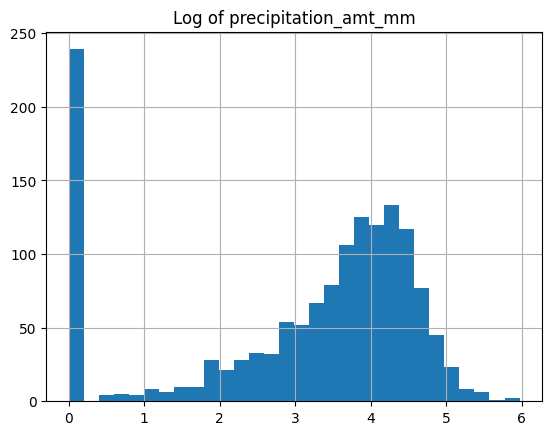

In [9]:
np.log1p(data.precipitation_amt_mm).hist(bins=30)
plt.title('Log of precipitation_amt_mm')
plt.show()

# Missing Data

We see that for SJ it's mostly vegetation data is missing (up to 20%) whereas for IQ it's mostly temperature data and there's less data that's missing (up to 8%)

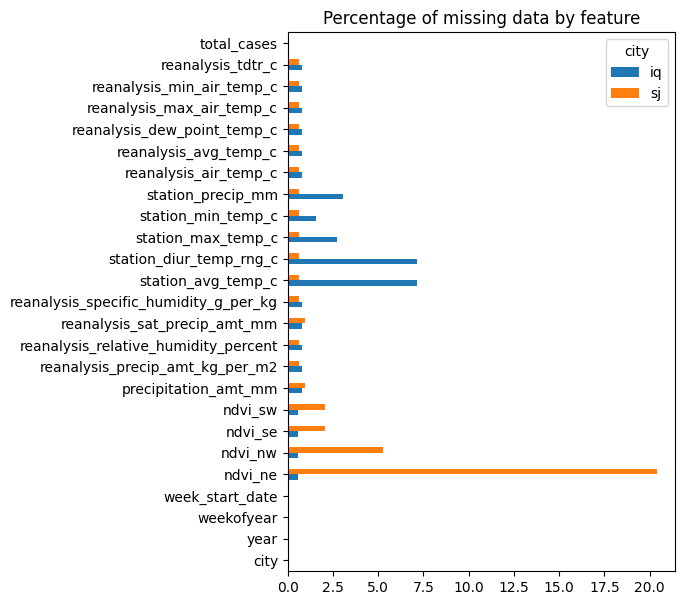

In [10]:
missing_pct = data.groupby('city').apply(lambda x: 100 * x.isnull().mean()).T

missing_pct.plot.barh(figsize=(5, 7))
plt.title('Percentage of missing data by feature')
plt.show()

# Imputation

As long as we're dealing with weekly values, it makes sense to impute with value from previous week as there could be sharp changes for daily values but those will be smoothed out on the weekly scale.

In [11]:
data = data.ffill()

# Correlation Structure

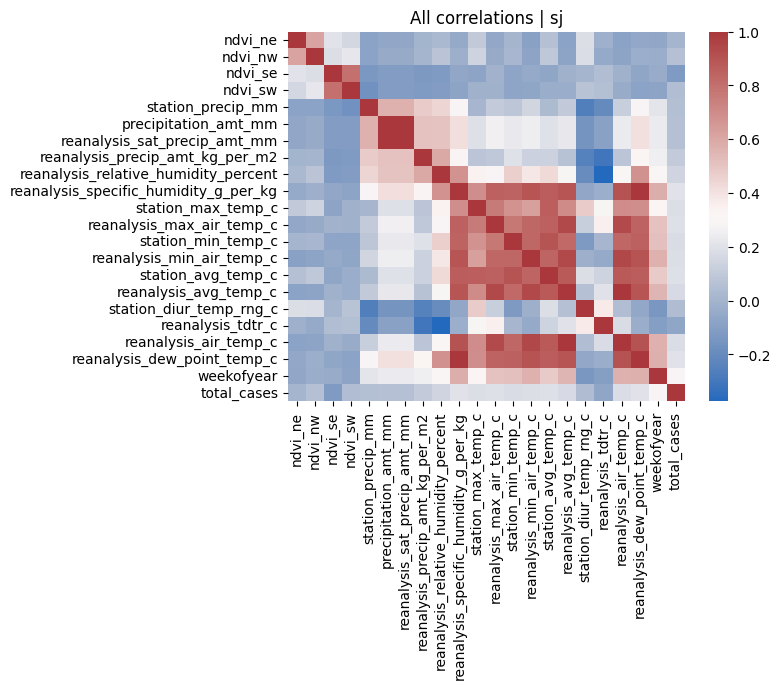

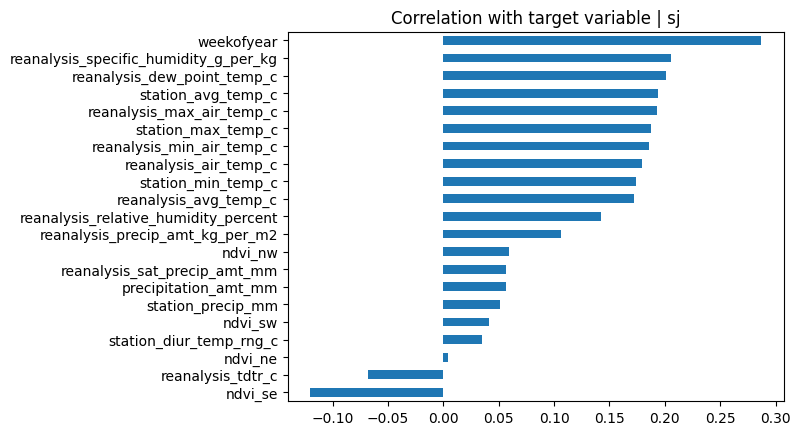

In [12]:
sj = data[data.city == 'sj'].drop(columns=['city'])
iq = data[data.city == 'iq'].drop(columns=['city'])

corr_plot(sj, cols=features + ['weekofyear'], title='sj')

We can clearly see temperature (except for temperature ranges) and specific humidity form a cluster of high correlation. Slightly weaker correlation is observed for precipitation and relative humidity. Correlation is also seen for vegetation index for north and south directions separately. Vegetation data is mildly negatively correlated with the rest of the climate data.

Bottom plot shows correlation with the target variable. We see that the highest correlation is with `weekofyear` which hints at a strong seasonal component which is followed by temperature quantities (not temperature range though) and humidity with noticeable negative correlation with SE vegetation index. This makes sense as the disease is clearly seasonal and is aided by high temperature, precipitation and humidity serving as mosquitos flourish in wet warm environments.

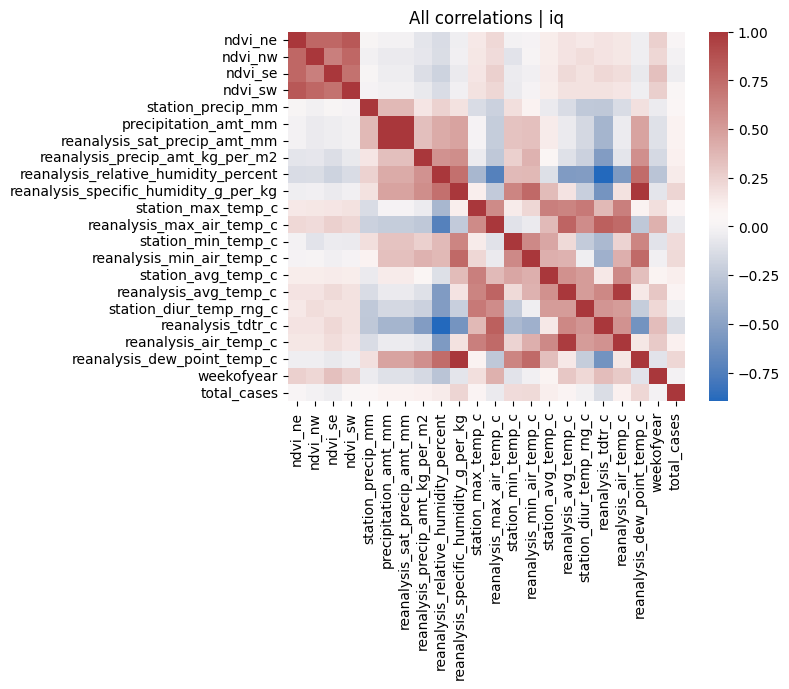

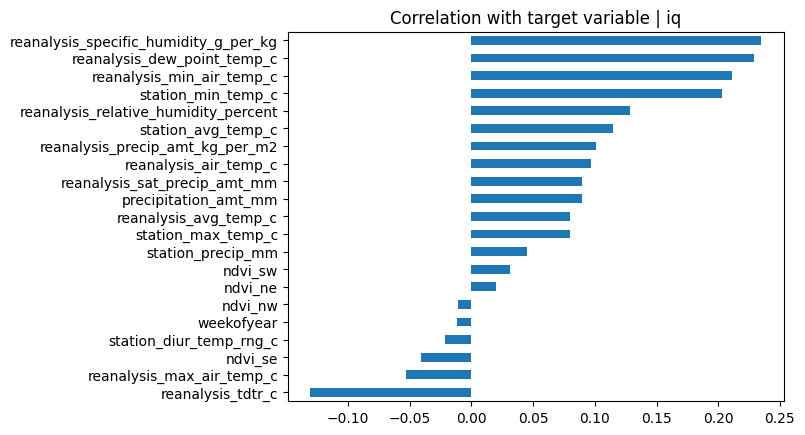

In [13]:
corr_plot(iq, cols=features + ['weekofyear'], title='iq')

A very different picture is seen for IQ. The strongest correlation cluster is formed by vegetation data followed by temperature and precipitation. Also climate data seem to have a more direct impact on the target variable `total_counts` and not seasonality.
Absolute temperature quantities along with humidity and precipitation contribute positively to the disease spread, while temperature ranges have a noticeable negative impact. 

# Incorporation of Different Sources

The heatmaps also indicate strong correlations between measurement of the same quantities coming from different data sources. For example, `reanalysis_max_air_temp_c` and `station_max_temp_c` should be measuring the same thing, yet their distributions are not the same but the values are highly correlated at 0.76. There is unlikely\* to be differences in what is measured but rather how it's measured. We assume differences in methodology and that the measurements were done with the same frequency. As a result it makes sense to average these features. This would naturally reduce problem dimensionality while reducing noise and dependence on unknown methodology.

\*Small note here: some links to the data source descriptions are broken so it's hard to know for sure these are measuring the same quantities and not one is measuring air temp 2 meters above the ground and the other is measuring some surface temp.

corr = 0.76


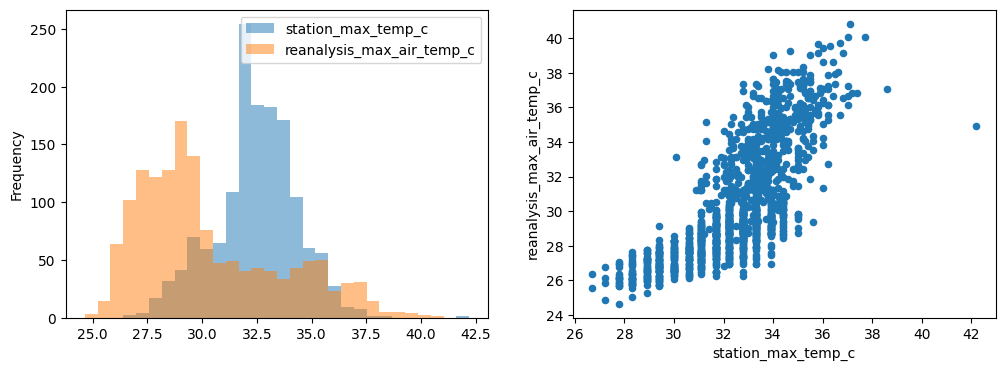

In [14]:
compare_vars(data, 'station_max_temp_c', 'reanalysis_max_air_temp_c')

Correlation structure stays intact after averaging

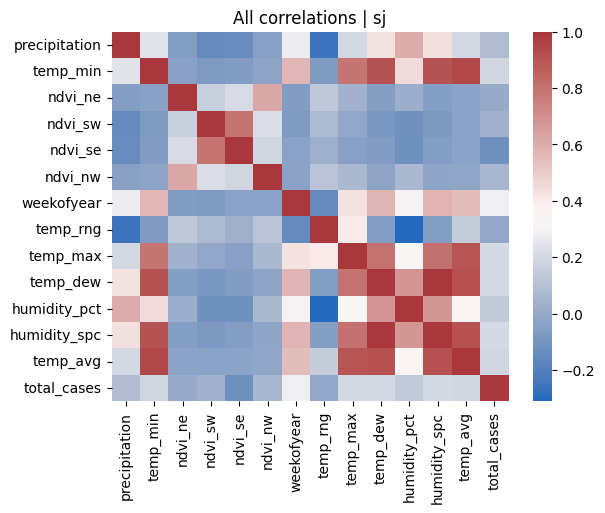

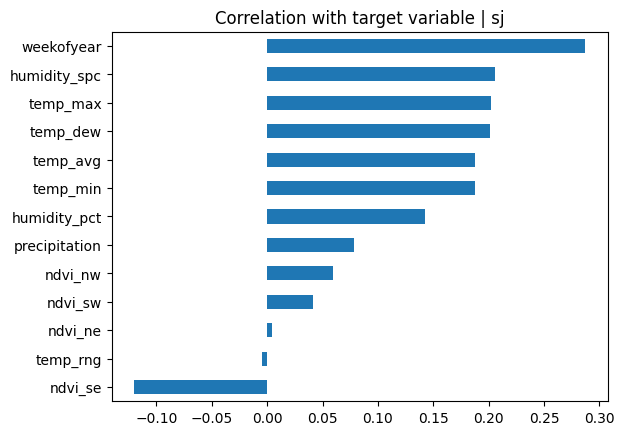

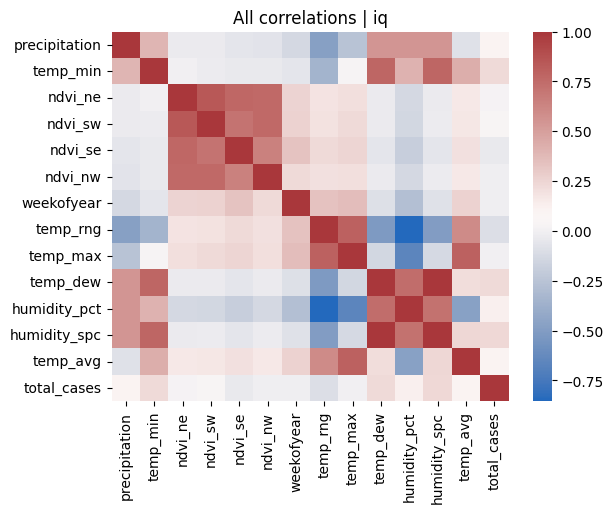

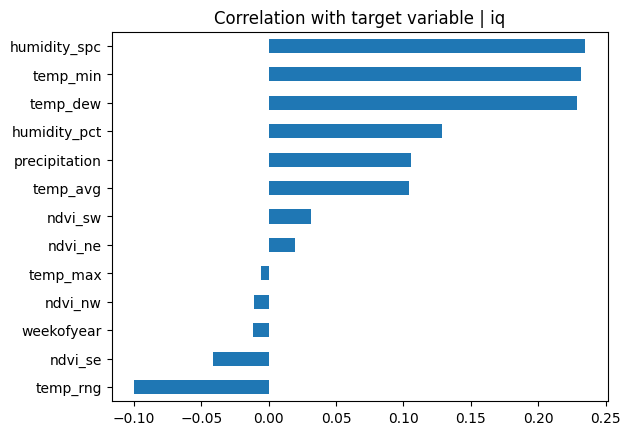

In [15]:
data_manager = Data('data/dengue_features_train.csv', 'data/dengue_labels_train.csv')
data = data_manager.get_xy()

sj = data[data.is_sj == 1].drop(columns=['is_sj'])
iq = data[data.is_sj == 0].drop(columns=['is_sj'])

corr_plot(sj, title='sj')
corr_plot(iq, title='iq')

# Seasonal Component

To investigate, we group by week of year and take average. We observe strong seasonal components in all climate variables.

In [16]:
data_manager = Data('data/dengue_features_train.csv', 'data/dengue_labels_train.csv')
data = data_manager.get_xy()
sj = data[data['is_sj'] == 1].drop(columns=['is_sj'])
iq = data[data['is_sj'] == 0].drop(columns=['is_sj'])

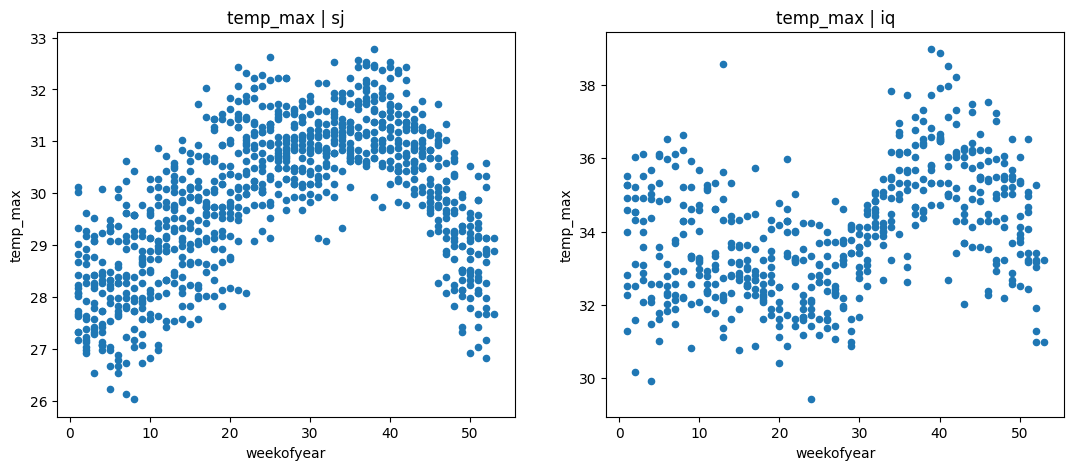

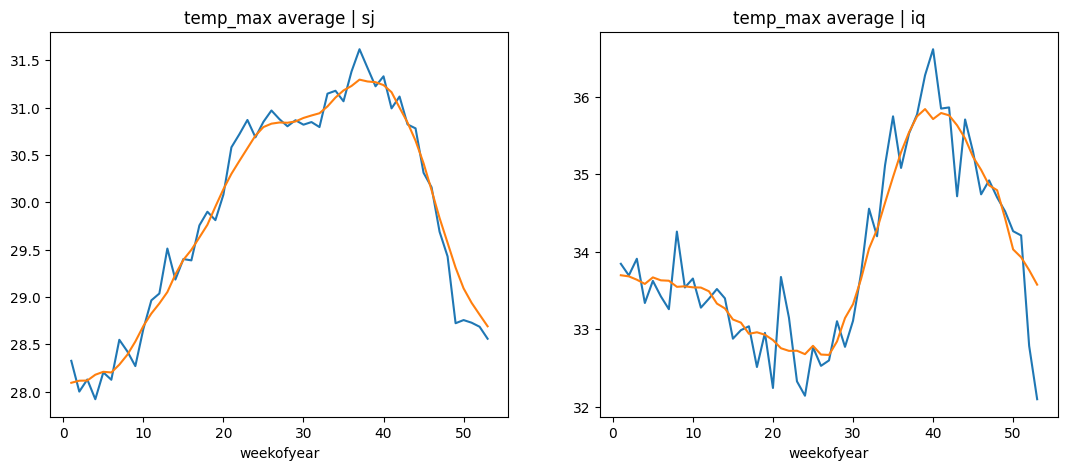

In [17]:
pattern_sj = {}
pattern_iq = {}
for c in data_manager.get_climate_and_target_cols():
    pattern_sj[c], pattern_iq[c] = get_seasonal_pattern(c, sj, iq, plot='max' in c)
pattern_sj = pd.DataFrame(pattern_sj)
pattern_iq = pd.DataFrame(pattern_iq)

Below we can clearly see a seasonal pattern for both climate and disease spread data. We see total cases lagging some climate data, hence it makes sense exploring lead-lag correlations

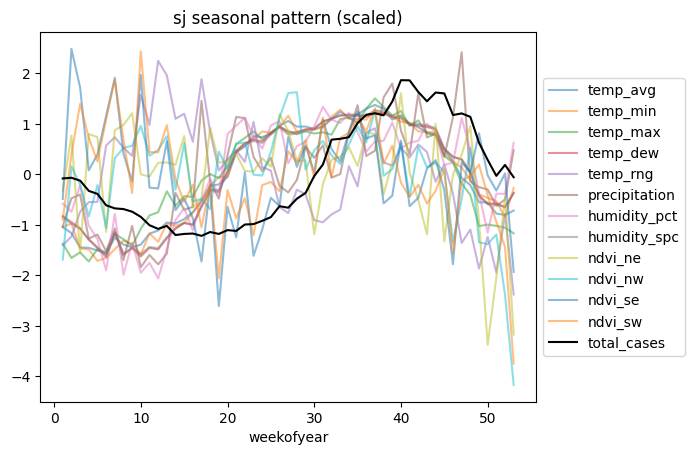

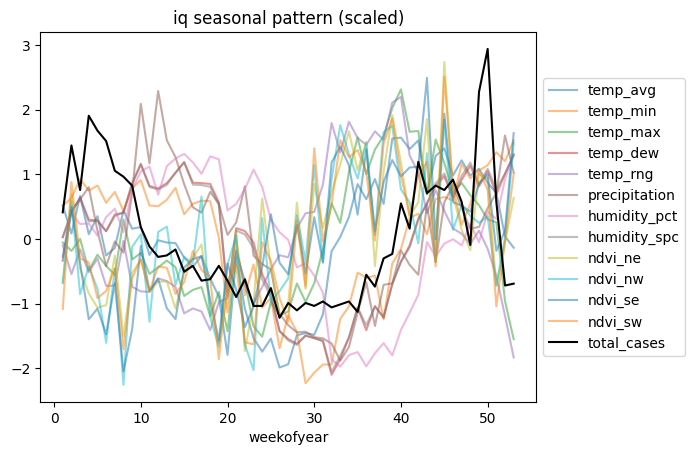

In [18]:
norm = normalize(pattern_sj)

norm[data_manager.get_climate_cols()].plot(alpha=0.5)
norm[data_manager.get_target_col()].plot(c='k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('sj seasonal pattern (scaled)')
plt.show()

norm = normalize(pattern_iq)
norm[data_manager.get_climate_cols()].plot(alpha=0.5)
norm[data_manager.get_target_col()].plot(c='k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('iq seasonal pattern (scaled)')
plt.show()

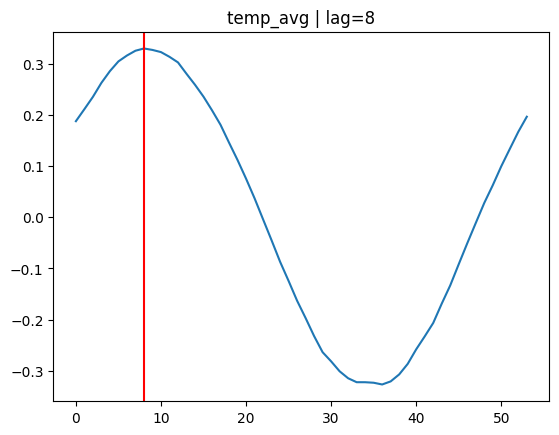

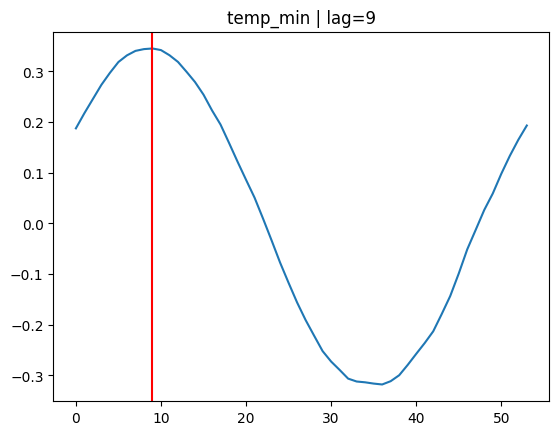

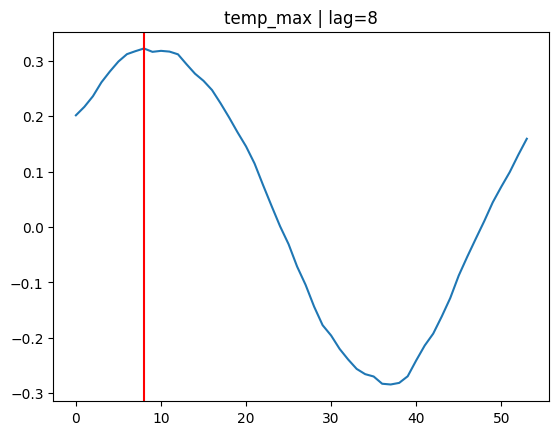

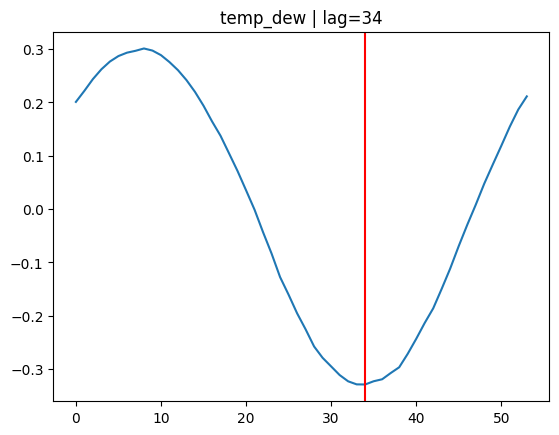

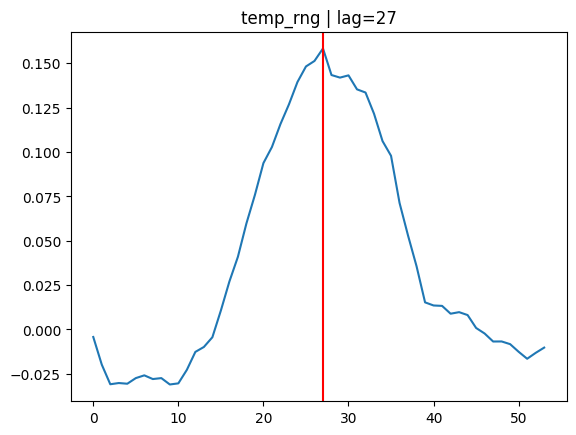

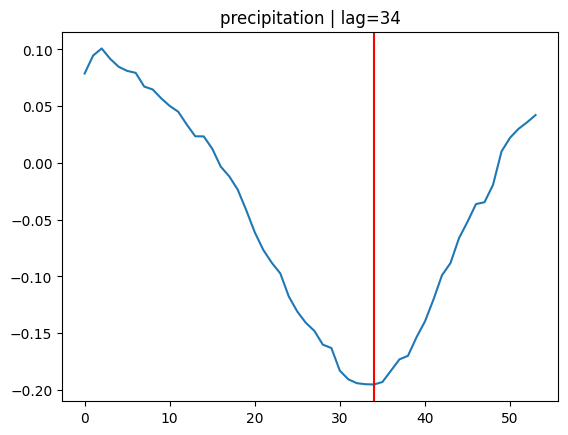

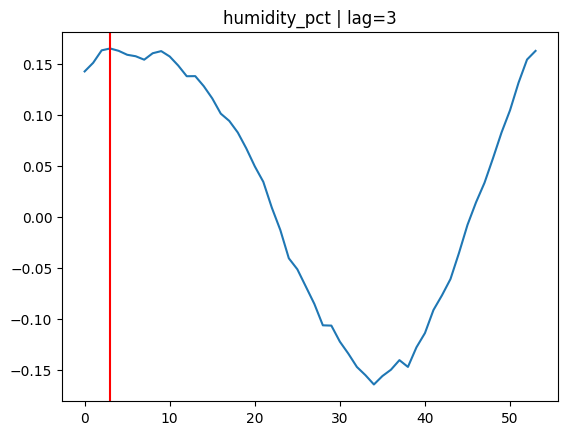

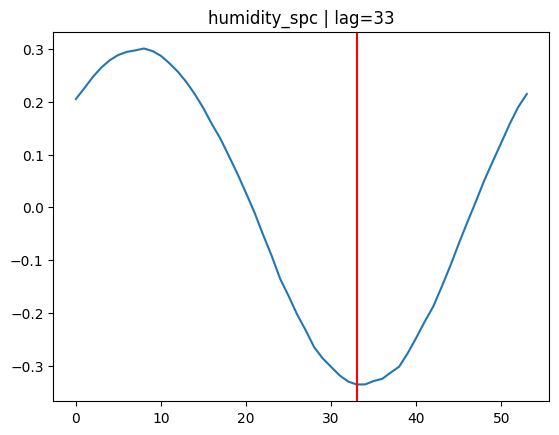

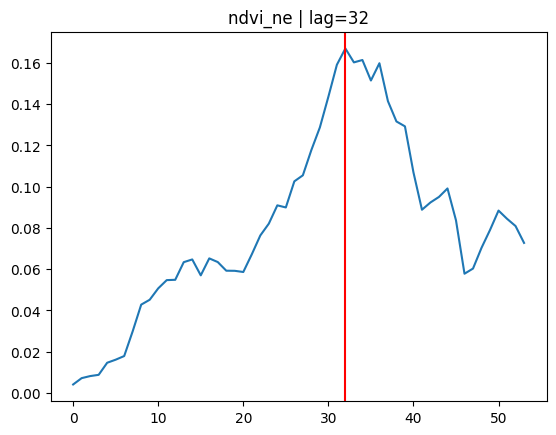

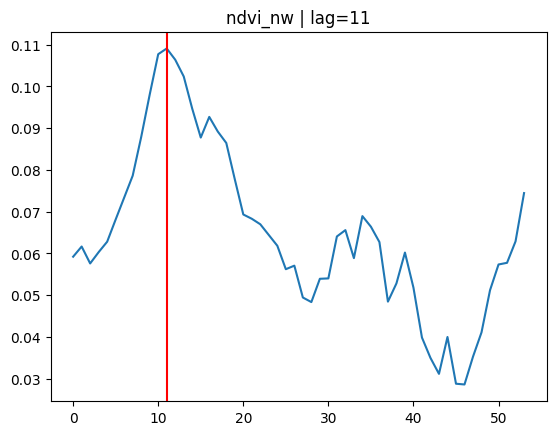

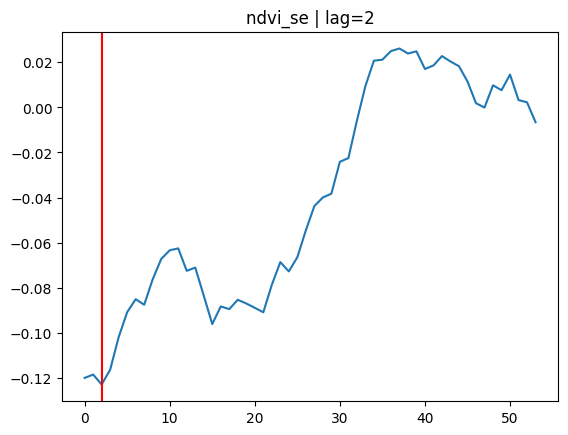

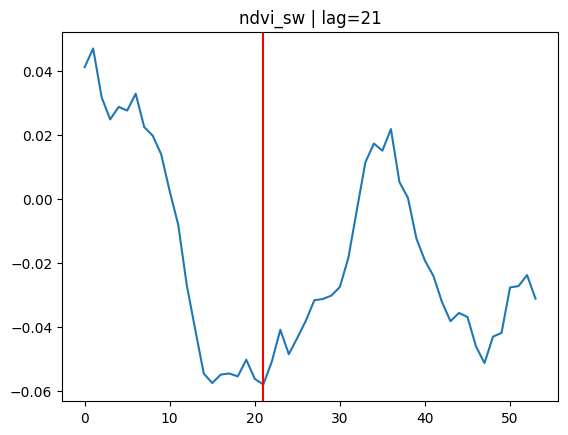

In [19]:
df = data[data.is_sj == 1]

lags = {}
for c in data_manager.get_climate_cols():
    x = df[c]
    y = df[data_manager.get_target_col()]
    corr = pd.Series({n: x.shift(n).corr(y) for n in range(53 + 1)})
    corr.plot()
    lag = corr.index[corr.abs().argmax()]
    lags[c] = lag if lag != 25 else None
    plt.axvline(lag, c='r')
    plt.title(f'{c} | lag={lag}')
    plt.show()

Some observations:

1. Temperature related features are leading target variable by approximately 8 weeks (I'll ignore variability in this number for the sake of model simplicity)
2. Precipitation and humidity features are leading by approx 3 weeks

It makes sense to introduce new features that represent temperature values 8 weeks ago and precipitation and humidity values by 3.

Below we see that these new features are among the top features in terms of correlation with the target (that was by design though).

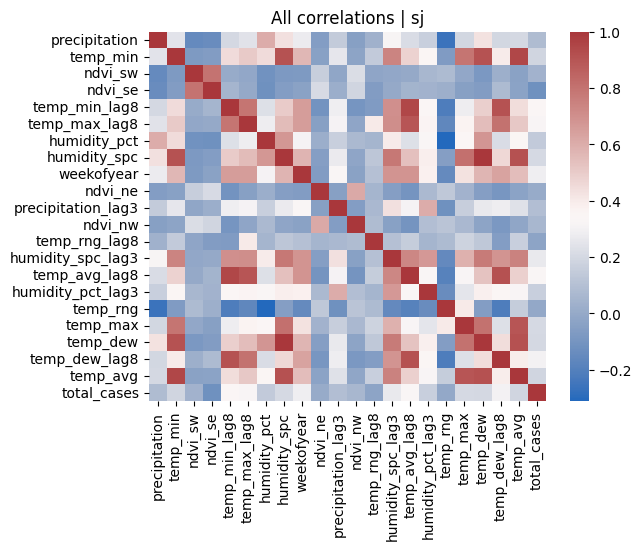

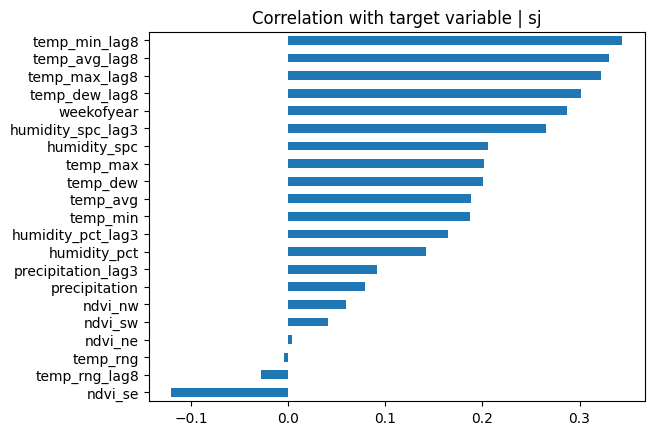

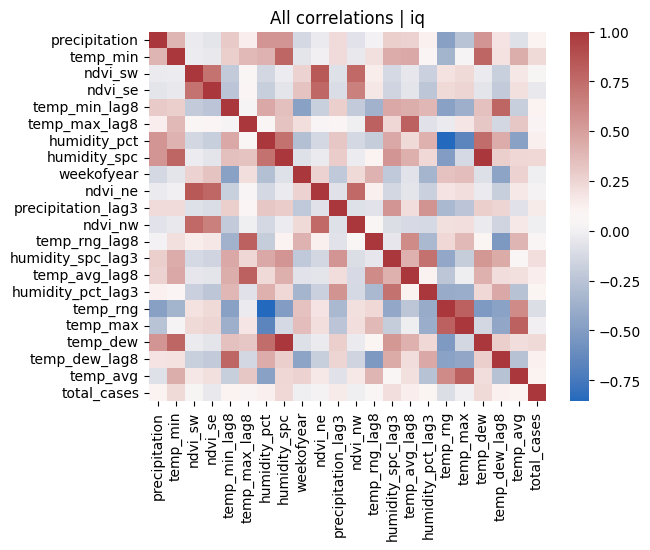

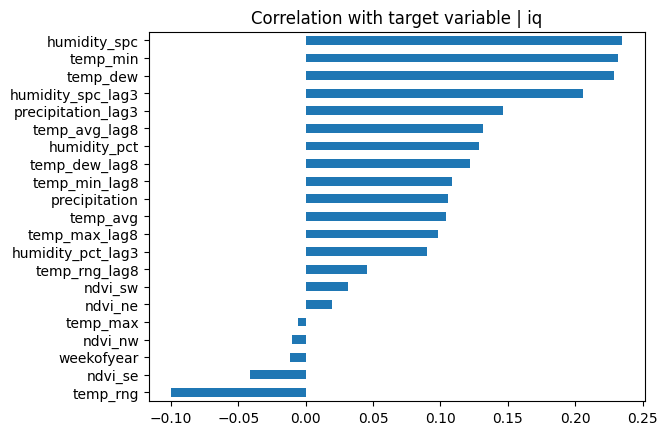

In [20]:
sj_shifted = data_manager.get_shifted(sj)
iq_shifted = data_manager.get_shifted(iq)

corr_plot(sj_shifted, title='sj')
corr_plot(iq_shifted, title='iq')

# Seasonal Residuals

Another way of dealing with seasonality would be to explicitly subtract seasonal components from predictor and response variables and fit models on the residuals. This completely reduces correlation to week of year

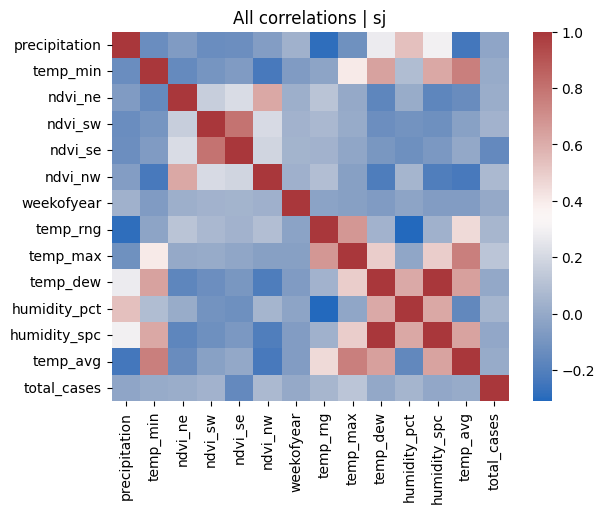

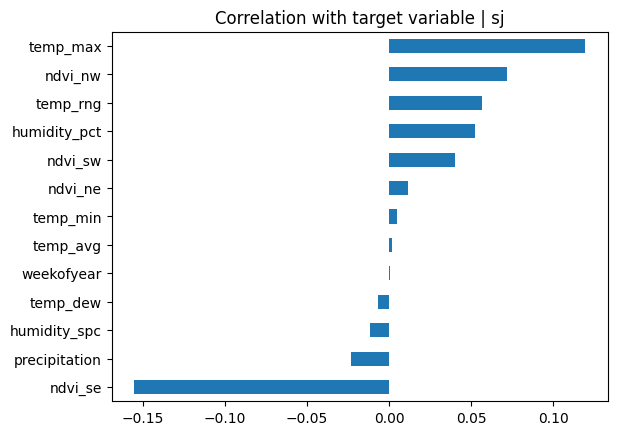

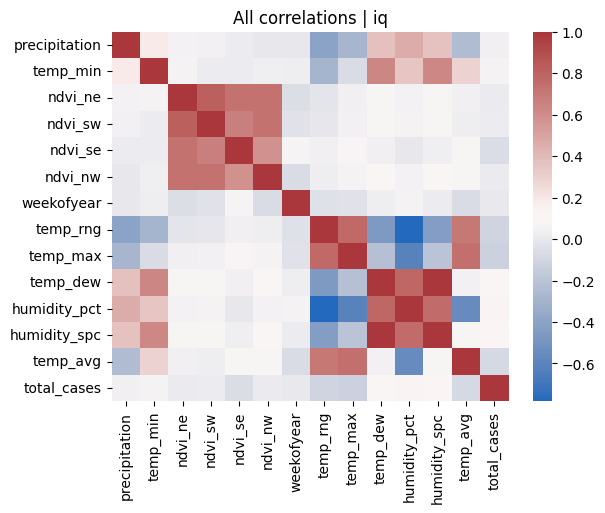

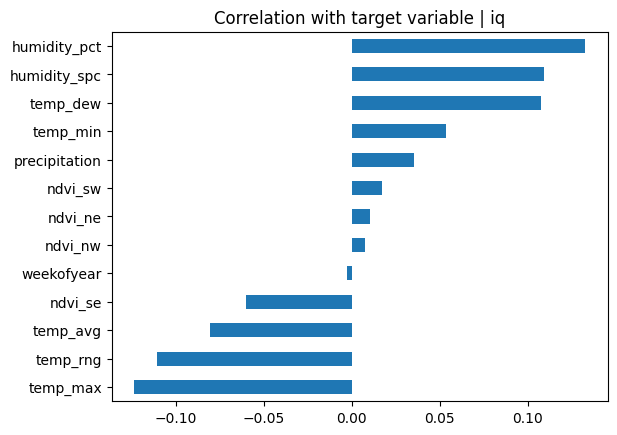

In [21]:
data_manager = Data('data/dengue_features_train.csv', 'data/dengue_labels_train.csv')
data = data_manager.deseason_and_get_xy()
sj = data[data['is_sj'] == 1].drop(columns=['is_sj'])
iq = data[data['is_sj'] == 0].drop(columns=['is_sj'])

corr_plot(sj, title='sj')
corr_plot(iq, title='iq')